In [6]:
# add dependencies
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import time
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import Column, Integer, String, Float, and_, Date, desc, func

In [68]:
# collect the start and end dates of the trips
date_entry = input('Enter a start date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
start_date = datetime.date(year, month, day)

date_entry = input('Enter an end date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
end_date = datetime.date(year, month, day)

Enter a start date for your trip in YYYY-MM-DD format: 2017-05-23
Enter an end date for your trip in YYYY-MM-DD format: 2017-06-03


In [69]:
# Use create the engine and assign classes
engine = create_engine("sqlite:///hawaii.sqlite")

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

Station = Base.classes.stations
Measurement = Base.classes.measurements

session = Session(engine)

In [82]:
# get the date 1 year ago
year_ago = end_date - datetime.timedelta(365)
#print (year_ago)

pcp_year = session.query(Measurement.date, Measurement.prcp).filter(and_(Measurement.date <= end_date,
                                                                        Measurement.date >= year_ago)).all()

# create the dataframe and set date as the index
pcp_df = pd.DataFrame(pcp_year, columns=["date", "precipitation"])
pcp_df.set_index('date', inplace=True)
pcp_df.head()

,precipitation
date,
2016-06-03,0.00
2016-06-04,0.00
2016-06-05,0.00
2016-06-06,0.00
2016-06-07,0.01


In [83]:
pcp_df.describe()

,precipitation
count,2060.000000
mean,0.213845
std,0.571187
min,0.000000
25%,0.000000
50%,0.020000
75%,0.160000
max,9.640000


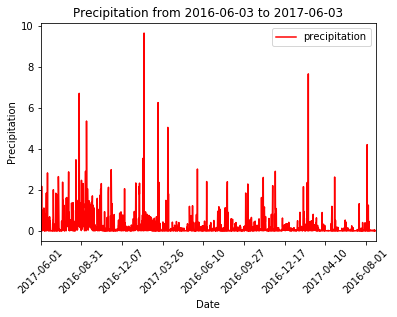

In [84]:
pcp_df.iloc[::-1].plot(color = "red")
plt.xlabel("Date")
plt.xticks(rotation =45)
plt.ylabel("Precipitation")
plt.title("Precipitation from %s to %s" %(year_ago,end_date))
plt.show()

In [85]:
# calculate the number of stations
num_stations = session.query(Station.station).count()
print("The number of stations is: %s" % num_stations)

The number of stations is: 9


In [86]:
# find the most active station
act_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).all()

most_active = act_stations[0][0]
num_observations = act_stations[0][1]

print("The most active station is: %s" % most_active)
print("Number of observations for station %s: %s" % (most_active, num_observations))

The most active station is: USC00519281
Number of observations for station USC00519281: 2772


In [87]:
# get the last 12 months of temperature data
temp_year = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.date <= end_date,
                                                                        Measurement.date >= year_ago,
                                                                         Measurement.station == most_active)).all()

# create the dataframe and set date as the index
temp_df = pd.DataFrame(temp_year, columns = ["date", "temperature"])
temp_df.set_index('date', inplace=True)

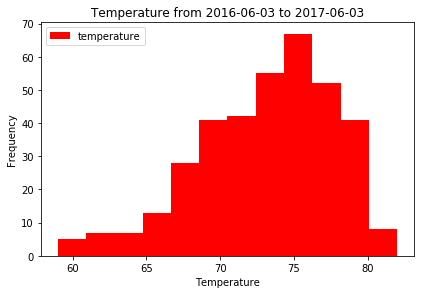

In [88]:
# create a histogram of the temperature data
temp_df.iloc[::-1].plot.hist(title="Temperature from %s to %s" % (year_ago, end_date), bins = 12,color="red")
plt.tight_layout()
plt.xlabel("Temperature")
plt.show()

In [103]:
def calc_temps(start, end):
    # calculate the date 1 year ago
    one_year = end - datetime.timedelta(365)
    
    # get the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= one_year)).all()
    maximum = max_temp[0][0]
    
    # get the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= one_year)).all()
    minimum = min_temp[0][0]
    
    # get the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= one_year)).all()
    average = avg_temp[0][0]
    # create the plot
    objects = [str(end)]
    x_axis = np.arange(len(objects))
    fig, ax = plt.subplots()
    temp_plot = ax.bar(x_axis, average, yerr=(maximum-minimum), color = "orange", alpha = .50, width = .65)
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, [])
    plt.xlim(-1, len(x_axis))
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.tight_layout()
    plt.show()

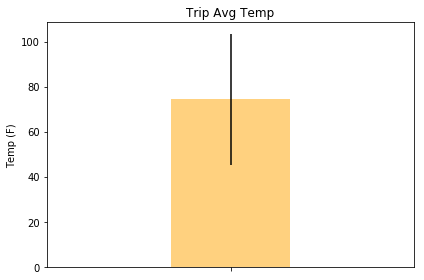

In [104]:
# call the function
calc_temps(start_date, end_date)

In [97]:
# calcualte rainfall per weather station using previous year's matching date
total_prcp = session.query(Measurement.station, func.sum(Measurement.prcp)).group_by(Measurement.station).all()

total_prcp_df = pd.DataFrame(total_prcp, columns=["Station", "Total Precipitation from %s to %s" % (year_ago, end_date)])
total_prcp_df.head(num_stations)

,Station,Total Precipitation from 2016-06-03 to 2017-06-03
0,USC00511918,92.68
1,USC00513117,382.62
2,USC00514830,234.49
3,USC00516128,1068.09
4,USC00517948,43.44
5,USC00518838,70.87
6,USC00519281,588.64
7,USC00519397,131.62
8,USC00519523,295.68


In [99]:

# calculate daily normals
def daily_normals(day):
    s_month = day.strftime('%m')
    s_day = day.strftime('%d')
    
    # get the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ s_month + "-" + s_day)).all()
    maximum = max_temp[0][0]
    
    # get the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ s_month + "-" + s_day)).all()
    minimum = min_temp[0][0]
    
    # get the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ s_month + "-" + s_day)).all()
    average = avg_temp[0][0]
    
    return maximum, minimum, average

# get the range of dates for the chart
start = start_date
delta = datetime.timedelta(days=1)
date_range = []
while start <= end_date:
    date_range.append(start)
    start += delta

# get the max/min/avg of each day
ranges = []
date_data = {}

# get the max/min/avg for each day using a for loop, store in dict
for date in date_range:
    m,mi,av = daily_normals(date)
    ranges.append({"Date": date, "tmax": m, "tmin": mi, "tavg":av})
    
# create dataframe from dict
date_df = pd.DataFrame(ranges)

date_df.head()

,Date,tavg,tmax,tmin
0,2017-05-23,74.890909,87,68
1,2017-05-24,74.145455,79,69
2,2017-05-25,74.210526,79,68
3,2017-05-26,74.076923,82,65
4,2017-05-27,74.442308,80,65


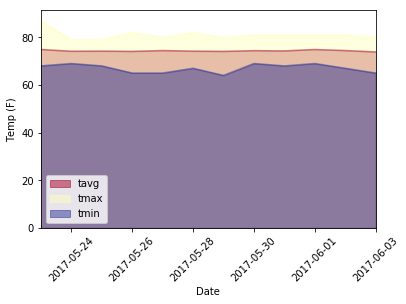

In [105]:
# make the area plot
date_df.plot.area(x = date_df["Date"], stacked = False, colormap='RdYlBu')
plt.xticks(rotation=45)
plt.ylabel("Temp (F)")
plt.show()